## Importing CNN from In-class assignment and testing on MNIST Dataset

In [48]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Lambda, Dense
from keras.layers.convolutional import Conv2D
from tensorflow.keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
import imageio
from tensorflow_docs.vis import embed
from keras import backend as K
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras.callbacks import EarlyStopping


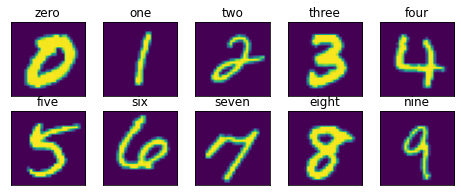

Epoch 1/5
469/469 [==============================] - 485s 1s/step - loss: 0.8089 - accuracy: 0.9449 - val_loss: 0.0526 - val_accuracy: 0.9838
Epoch 2/5
469/469 [==============================] - 487s 1s/step - loss: 0.0235 - accuracy: 0.9929 - val_loss: 0.0469 - val_accuracy: 0.9842
Epoch 3/5
469/469 [==============================] - 486s 1s/step - loss: 0.0083 - accuracy: 0.9976 - val_loss: 0.0523 - val_accuracy: 0.9846
Epoch 4/5
469/469 [==============================] - 487s 1s/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.0549 - val_accuracy: 0.9859
Epoch 5/5
313/313 [==============================] - 15s 49ms/step - loss: 0.0576 - accuracy: 0.9857
Loss: 0.058
Accuracy: 0.986


In [27]:
np.random.seed(42)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
class_names = ['zero','one','two','three','four',
               'five','six','seven','eight', 'nine']
fig = plt.figure(figsize=(8,3))
for i in range(len(class_names)):
  ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
  idx = np.where(Y_train[:]==i)[0]
  features_idx = X_train[idx,::]
  img_num = np.random.randint(features_idx.shape[0])
  im = features_idx[img_num,::]
  ax.set_title(class_names[i])
  #im = np.transpose(features_idx[img_num,::], (1, 2, 0))
  plt.imshow(im)
plt.show()
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
# Initializing the model
model = Sequential()
# Defining a convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# Defining a second convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Defining a third convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# We add our classificator
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001, decay=1e-6),
              metrics=['accuracy'])
# Training of the model
model.fit(X_train, to_categorical(Y_train),
          batch_size=128,
          shuffle=True,
          epochs=5,
          validation_data=(X_test, to_categorical(Y_test)))
# Evaluation of the model
scores = model.evaluate(X_test, to_categorical(Y_test))
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

I can see that the accuracy with the existing CNN is pretty accurate. I can also see that the accuracy is pretty high at above 98%. This shows that the existing CNN model that we have from our in class assignment is good with this dataset.

## CGAN

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [12]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [13]:
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [14]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)


138 11


### Discriminator

In [15]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

### Generator

In [16]:
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)


### Create Model

In [17]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

### Train Model

In [18]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20
1094/1094 [==============================] - 869s 794ms/step - g_loss: 1.5437 - d_loss: 0.4126
Epoch 2/20
1094/1094 [==============================] - 842s 770ms/step - g_loss: 1.3796 - d_loss: 0.4745
Epoch 3/20
1094/1094 [==============================] - 817s 747ms/step - g_loss: 1.3663 - d_loss: 0.4737
Epoch 4/20
1094/1094 [==============================] - 823s 752ms/step - g_loss: 1.8808 - d_loss: 0.2908
Epoch 5/20
1094/1094 [==============================] - 824s 753ms/step - g_loss: 1.8964 - d_loss: 0.3566
Epoch 6/20
1094/1094 [==============================] - 796s 728ms/step - g_loss: 0.9431 - d_loss: 0.6494
Epoch 7/20
1094/1094 [==============================] - 782s 715ms/step - g_loss: 0.8755 - d_loss: 0.6587
Epoch 8/20
1094/1094 [==============================] - 802s 733ms/step - g_loss: 0.8243 - d_loss: 0.6700
Epoch 9/20
1094/1094 [==============================] - 781s 713ms/step - g_loss: 0.7918 - d_loss: 0.6776
Epoch 10/20
1094/1094 [=======================

In [19]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 1  # @param {type:"slider", min:0, max:9, step:1}
end_class = 5  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)


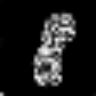

In [26]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")

While some of the labels look the same, you can see the some distinctions between each class too. Next I can try a CVAE to see of it will work better

## Conditional Variational Autoencoder

### Setting up data

In [17]:

import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import save_img
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
from IPython import display
warnings.filterwarnings('ignore')
%pylab inline
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
(train_images, _), (test_images, _) = mnist.load_data()
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

### Hyperparameters

In [4]:
train_size = 60000
batch_size = 32
test_size = 10000

### Batch and shuffle the data

In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

### Creating Encoder and Decoder

In [8]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

### Loss function

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Making graphs

In [78]:
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

### Training Model

In [10]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [11]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [12]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

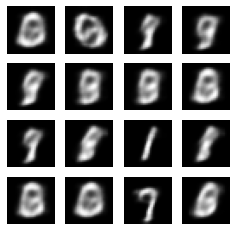

Epoch: 1, Test set ELBO: -163.46656799316406, time elapse for current epoch: 30.780956268310547


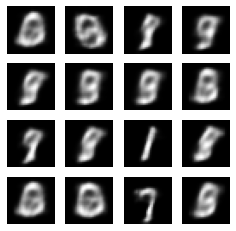

Epoch: 2, Test set ELBO: -161.01461791992188, time elapse for current epoch: 28.78397035598755


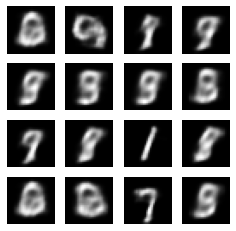

Epoch: 3, Test set ELBO: -159.8441925048828, time elapse for current epoch: 31.450385093688965


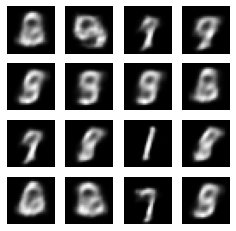

Epoch: 4, Test set ELBO: -158.5095672607422, time elapse for current epoch: 32.359999656677246


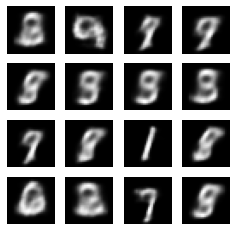

Epoch: 5, Test set ELBO: -157.47206115722656, time elapse for current epoch: 31.55199909210205


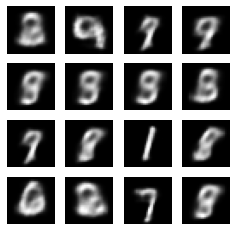

Epoch: 6, Test set ELBO: -156.8545379638672, time elapse for current epoch: 29.93197202682495


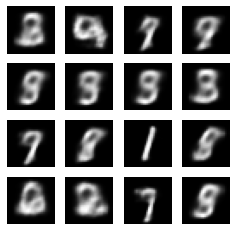

Epoch: 7, Test set ELBO: -156.1895751953125, time elapse for current epoch: 29.72897171974182


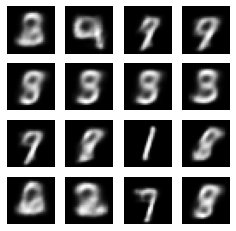

Epoch: 8, Test set ELBO: -155.5404815673828, time elapse for current epoch: 34.573967933654785


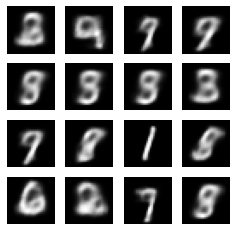

Epoch: 9, Test set ELBO: -155.212890625, time elapse for current epoch: 32.68897724151611


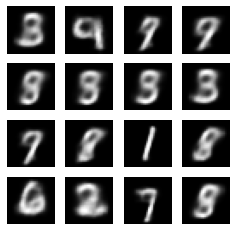

Epoch: 10, Test set ELBO: -154.8896942138672, time elapse for current epoch: 31.999523401260376


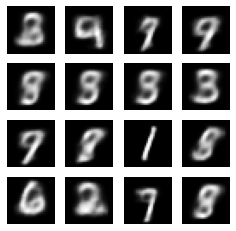

In [19]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  #display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

### Animated Gif

In [21]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


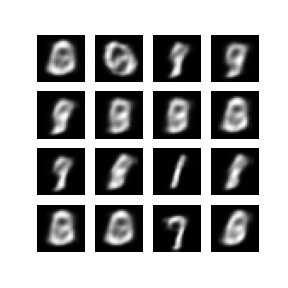

In [22]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

I can see the images getting slighly clearer every time through the animation but there is still some blurriness in it

# Comparing the CGAN and CVAE

In conclusion, I could see that both models have their problems. While the CGAN was generating a lot of pixelated images, the CVAE had a lot of blurriness problems and bias towards one number. It was still impressive to see how images of numbers were able to be generated with just these inputs, even if some of them of them donâ€™t look accurate. 